In [1]:
import torch
from librosa.filters import mel as librosa_mel_fn

mel_basis = {}
hann_window = {}

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def mel_spectrogram(
    y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False
):
    if torch.min(y) < -1.0:
        print("min value is ", torch.min(y))
    if torch.max(y) > 1.0:
        print("max value is ", torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(
            sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax
        )
        mel_basis[str(fmax) + "_" + str(y.device)] = (
            torch.from_numpy(mel).float().to(y.device)
        )
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(
        y.unsqueeze(1),
        (int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2)),
        mode="reflect",
    )
    y = y.squeeze(1)

    spec = torch.stft(
        y,
        n_fft,
        hop_length=hop_size,
        win_length=win_size,
        window=hann_window[str(y.device)],
        center=center,
        pad_mode="reflect",
        normalized=False,
        onesided=True,
        return_complex=False,
    )
    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9))

    spec = torch.matmul(mel_basis[str(fmax) + "_" + str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [7]:
import jax
import math
from jax import numpy as jnp, lax
from typing import Any, Optional


@jax.jit
def batch_pad(xs, pad: int, mode="reflect"):
    if xs.ndim == 2:
        pad_arg = [(0, 0), (pad, pad)]
    elif xs.ndim == 3:
        pad_arg = [(0, 0), (pad, pad), (0, 0)]
    else:
        pad_arg = [(pad, pad)]
    xs = jnp.pad(xs, pad_arg, mode=mode)
    return xs


@jax.jit
def _conv_dimension_numbers(input_shape):
    """Computes the dimension numbers based on the input shape."""
    ndim = len(input_shape)
    lhs_spec = (0, ndim - 1) + tuple(range(1, ndim - 1))
    rhs_spec = (ndim - 1, ndim - 2) + tuple(range(0, ndim - 2))
    out_spec = lhs_spec
    return lax.ConvDimensionNumbers(lhs_spec, rhs_spec, out_spec)


@jax.jit
def stft(
    inputs: jnp.ndarray,
    n_fft: int,
    hop_length: Optional[int] = None,
    win_length: Optional[int] = None,
    window: Optional[jnp.ndarray] = None,
    center: bool = True,
    onesided: Optional[bool] = None,
) -> jnp.ndarray:
    """Short-time Fourier transform using conv_general_dilated_patches."""

    # Handle default parameters
    win_length = win_length if win_length is not None else n_fft
    hop_length = hop_length if hop_length is not None else n_fft // 4

    if window is None:
        window = jnp.ones(win_length)

    # Input normalization and reshape to (batch, time, channels)
    inputs = jnp.asarray(inputs)
    if inputs.ndim == 1:
        inputs = inputs.reshape(1, -1, 1)
    elif inputs.ndim == 2:
        inputs = inputs[..., None]

    is_real = jnp.issubdtype(inputs.dtype, jnp.floating)

    # Extract frames using convolution
    frames = lax.conv_general_dilated_patches(
        lhs=inputs,
        filter_shape=(1024,),
        window_strides=(256,),
        padding="VALID",
        dimension_numbers=jax.lax.ConvDimensionNumbers(
            lhs_spec=(0, 2, 1), rhs_spec=(2, 1, 0), out_spec=(0, 2, 1)
        ),
    )

    # Apply window
    frames = frames * window[None, None, :]

    # Compute FFT
    output = jnp.fft.fft(frames, n=1024, axis=-1)

    # Handle onesided output
    if onesided is None:
        onesided = is_real

    # if onesided:
    output = output[..., : (1024 // 2) + 1]

    return output


# @jax.jit
def _hz_to_mel(freq: float, mel_scale: str = "htk") -> float:
    r"""Convert Hz to Mels.

    Args:
        freqs (float): Frequencies in Hz
        mel_scale (str, optional): Scale to use: ``htk`` or ``slaney``. (Default: ``htk``)

    Returns:
        mels (float): Frequency in Mels
    """
    if mel_scale not in ["slaney", "htk"]:
        raise ValueError('mel_scale should be one of "htk" or "slaney".')

    if mel_scale == "htk":
        return 2595.0 * math.log10(1.0 + (freq / 700.0))

    # Fill in the linear part
    f_min = 0.0
    f_sp = 200.0 / 3

    mels = (freq - f_min) / f_sp
    min_log_hz = 1000.0
    min_log_mel = (min_log_hz - f_min) / f_sp
    logstep = jnp.log(6.4) / 27.0

    if freq >= min_log_hz:
        mels = min_log_mel + jnp.log(freq / min_log_hz) / logstep
    return mels


# @jax.jit
def _mel_to_hz(mels: jnp.array, mel_scale: str = "htk") -> jnp.array:
    """Convert mel bin numbers to frequencies.

    Args:
        mels (jnp.array): Mel frequencies
        mel_scale (str, optional): Scale to use: ``htk`` or ``slaney``. (Default: ``htk``)

    Returns:
        freqs (Tensor): Mels converted in Hz
    """
    if mel_scale not in ["slaney", "htk"]:
        raise ValueError('mel_scale should be one of "htk" or "slaney".')
    if mel_scale == "htk":
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)
    # Fill in the linear scale
    f_min = 0.0
    f_sp = 200.0 / 3
    freqs = f_min + f_sp * mels

    # And now the nonlinear scale
    min_log_hz = 1000.0
    min_log_mel = (min_log_hz - f_min) / f_sp
    logstep = math.log(6.4) / 27.0

    freqs = jnp.where(
        mels >= min_log_mel,
        min_log_hz * jnp.exp(logstep * (mels - min_log_mel)),
        freqs,
    )
    # log_t = mels >= min_log_mel
    # freqs.at[log_t].set()
    return freqs


# @jax.jit
def _create_triangular_filterbank(
    all_freqs: jnp.array,
    f_pts: jnp.array,
) -> jnp.array:
    """Create a triangular filter bank.

    Args:
        all_freqs (Tensor): STFT freq points of size (`n_freqs`).
        f_pts (Tensor): Filter mid points of size (`n_filter`).

    Returns:
        fb (Tensor): The filter bank of size (`n_freqs`, `n_filter`).
    """
    # Adopted from Librosa
    # calculate the difference between each filter mid point and each stft freq point in hertz
    f_diff = f_pts[1:] - f_pts[:-1]  # (n_filter + 1)
    slopes = (
        f_pts[jnp.newaxis, Ellipsis] - all_freqs[Ellipsis, jnp.newaxis]
    )  # (n_freqs, n_filter + 2)
    # create overlapping triangles
    down_slopes = (-1.0 * slopes[:, :-2]) / f_diff[:-1]  # (n_freqs, n_filter)
    up_slopes = slopes[:, 2:] / f_diff[1:]  # (n_freqs, n_filter)
    fb = jnp.maximum(0.0, jnp.minimum(down_slopes, up_slopes))
    return fb


# @jax.jit
def melscale_fbanks(
    n_freqs: int,
    n_mels: int,
    sample_rate: int,
    f_min: float,
    f_max: Optional[float] = None,
    norm: Optional[str] = None,
    mel_scale: str = "htk",
) -> jnp.array:
    r"""Create a frequency bin conversion matrix.

    Args:
        n_freqs (int): Number of frequencies to highlight/apply
        f_min (float): Minimum frequency (Hz)
        f_max (float): Maximum frequency (Hz)
        n_mels (int): Number of mel filterbanks
        sample_rate (int): Sample rate of the audio waveform
        norm (str or None, optional): If 'slaney', divide the triangular mel weights by the width of the mel band
            (area normalization). (Default: ``None``)
        mel_scale (str, optional): Scale to use: ``htk`` or ``slaney``. (Default: ``htk``)

    Returns:
        Tensor: Triangular filter banks (fb matrix) of size (``n_freqs``, ``n_mels``)
        meaning number of frequencies to highlight/apply to x the number of filterbanks.
        Each column is a filterbank so that assuming there is a matrix A of
        size (..., ``n_freqs``), the applied result would be
        ``A * melscale_fbanks(A.size(-1), ...)``.

    """
    f_max = f_max if f_max is not None else float(sample_rate // 2)
    assert f_min <= f_max, "Require f_min: {} < f_max: {}".format(f_min, f_max)
    if norm is not None and norm != "slaney":
        raise ValueError("norm must be one of None or 'slaney'")
    all_freqs = jnp.linspace(0, sample_rate // 2, n_freqs)

    # calculate mel freq bins
    m_min = _hz_to_mel(f_min, mel_scale=mel_scale)
    m_max = _hz_to_mel(f_max, mel_scale=mel_scale)

    m_pts = jnp.linspace(m_min, m_max, n_mels + 2)
    f_pts = _mel_to_hz(m_pts, mel_scale=mel_scale)

    # create filterbank
    fb = _create_triangular_filterbank(all_freqs, f_pts)

    if norm is not None and norm == "slaney":
        # Slaney-style mel is scaled to be approx constant energy per channel
        enorm = 2.0 / (f_pts[2 : n_mels + 2] - f_pts[:n_mels])
        fb *= enorm[jnp.newaxis, Ellipsis]

    # if (fb.max(axis=0) == 0.).any():
    #     warnings.warn(
    #         "At least one mel filterbank has all zero values. "
    #         f"The value for `n_mels` ({n_mels}) may be set too high. "
    #         f"Or, the value for `n_freqs` ({n_freqs}) may be set too low."
    #     )
    return fb


def spectrogram(
    inputs: jnp.array,
    pad: int,
    window: jnp.array,
    n_fft: int,
    hop_length: int,
    win_length: int,
    power: Optional[float] = 2.0,
    normalized: bool = False,
    center: bool = True,
    onesided: bool = True,
    return_complex: bool = True,
) -> jnp.array:
    r"""Create a spectrogram or a batch of spectrograms from a raw audio signal.
    The spectrogram can be either magnitude-only or complex.

    Args:
        inputs (Tensor): Tensor of audio of dimension `(..., time)`
        pad (int): Two sided padding of signal
        window (Tensor): Window tensor that is applied/multiplied to each frame/window
        n_fft (int): Size of FFT
        hop_length (int): Length of hop between STFT windows
        win_length (int): Window size
        power (float or None): Exponent for the magnitude spectrogram,
            (must be > 0) e.g., 1 for energy, 2 for power, etc.
            If None, then the complex spectrum is returned instead.
        normalized (bool): Whether to normalize by magnitude after stft
        center (bool, optional): whether to pad :attr:`waveform` on both sides so
            that the :math:`t`-th frame is centered at time :math:`t \times \text{hop\_length}`.
            Default: ``True``
        pad_mode (string, optional): controls the padding method used when
            :attr:`center` is ``True``. Default: ``"reflect"``
        onesided (bool, optional): controls whether to return half of results to
            avoid redundancy. Default: ``True``
        return_complex (bool, optional):
            Indicates whether the underlying complex valued spectrogram is to be returned.
            If False, absolute value of the spectrogram is returned
            This argument is only effective when ``power=None``. It is ignored for
            cases where ``power`` is a number as in those cases, the returned tensor is
            power spectrogram, which is a real-valued tensor.

    Returns:
        Tensor: Dimension `(..., freq, time)`, freq is
        ``n_fft // 2 + 1`` and ``n_fft`` is the number of
        Fourier bins, and time is the number of window hops (n_frame).
    """
    # if power is None and not return_complex:
    #     raise ValueError(
    #         f"in correct combination of power(={power}) and return_complex(={return_complex}) provided."
    #     )

    # if pad > 0:
    #     inputs = batch_pad(inputs, pad, "zeros")

    spec_f = stft(
        inputs, n_fft, hop_length, win_length, window, center=center, onesided=onesided
    )
    # spec_f = jax.scipy.signal.stft(
    #     x=inputs,
    #     fs=22050,
    #     window=window,
    #     nperseg=win_length,
    #     nfft=n_fft,
    #     noverlap=win_length - hop_length,
    #     return_onesided=onesided,
    #     boundary=None,
    # )[2]
    # spec_f = (
    #     spec_f * jnp.sum(window) / 2
    # )  # Scipy schenanigans https://dsp.stackexchange.com/a/88383
    # spec_f = jnp.swapaxes(spec_f, axis1=1, axis2=2)

    if normalized:
        spec_f /= jnp.sqrt(jnp.sum(jnp.power(window, 2.0)))

    if power is not None:
        if power == 1.0:
            return jnp.abs(spec_f)
        return jnp.power(jnp.abs(spec_f), power)
    if not return_complex:
        return jnp.abs(spec_f)
    return spec_f


@jax.jit
def apply_melscale(
    spectrogram: jnp.array,
    precision: Any = lax.Precision.HIGHEST,
) -> jnp.array:
    r"""

    Args:
        spectrogram (jnp.array): A spectrogram STFT of dimension (..., time, freq)
        melscale_filterbank (jnp.array): MelScale filterbank of dimension (``n_freqs``, ``n_mels``)
        precision (jax.lax.Precision): Precision enum. Default value is  Precision.HIGHEST, which corresponds to FP32

    Returns
        jnp.array: A melspectrogram of dimension (..., time, ``n_mels``)
    """

    melscale_filterbank = melscale_fbanks(
        n_freqs=(1024 // 2) + 1,
        n_mels=80,
        sample_rate=22050,
        f_min=0.0,
        f_max=8000.0,
        mel_scale="slaney",
    )
    melspec = jnp.matmul(spectrogram, melscale_filterbank, precision=precision)
    return melspec

import jax
import soundfile as sf
import jax.numpy as jnp
from functools import partial

# creates a spectrogram helper
window = jnp.hanning(1024)
# window = jnp.hamming(1024)
spec_func = partial(spectrogram, pad=0, window=window, n_fft=1024,
                   hop_length=256, win_length=1024, power=2,
                   normalized=False, center=False, onesided=True, return_complex=True)
fb = melscale_fbanks(n_freqs=(1024//2)+1, n_mels=80,
                         sample_rate=22010, f_min=0., f_max=8000., norm="slaney", mel_scale="slaney")
mel_spec_func = partial(apply_melscale)


(1, 32, 513)
[[[29.908926   43.244877   16.183855   ... 34.51314    24.150982
    8.295224  ]
  [ 7.186319   29.699743    9.04279    ... 15.632777   14.848583
    3.8411057 ]
  [ 3.9400387  22.928926   49.050934   ... 92.259865   43.17566
   14.815131  ]
  ...
  [ 4.3814883  13.041184   16.960438   ... 44.669197   14.211767
   20.942606  ]
  [23.19116     2.247834    6.221068   ...  1.2361397  18.449677
   49.132824  ]
  [47.80884    21.437506    3.7556975  ...  0.26458412  7.907246
   34.595158  ]]]
[[[29.908926   43.244877   16.183855   ... 34.51314    24.150982
    8.295224  ]
  [ 7.186319   29.699743    9.04279    ... 15.632777   14.848583
    3.8411057 ]
  [ 3.9400387  22.928926   49.050934   ... 92.259865   43.17566
   14.815131  ]
  ...
  [ 4.3814883  13.041184   16.960438   ... 44.669197   14.211767
   20.942606  ]
  [23.19116     2.247834    6.221068   ...  1.2361397  18.449677
   49.132824  ]
  [47.80884    21.437506    3.7556975  ...  0.26458412  7.907246
   34.595158  ]]]
(

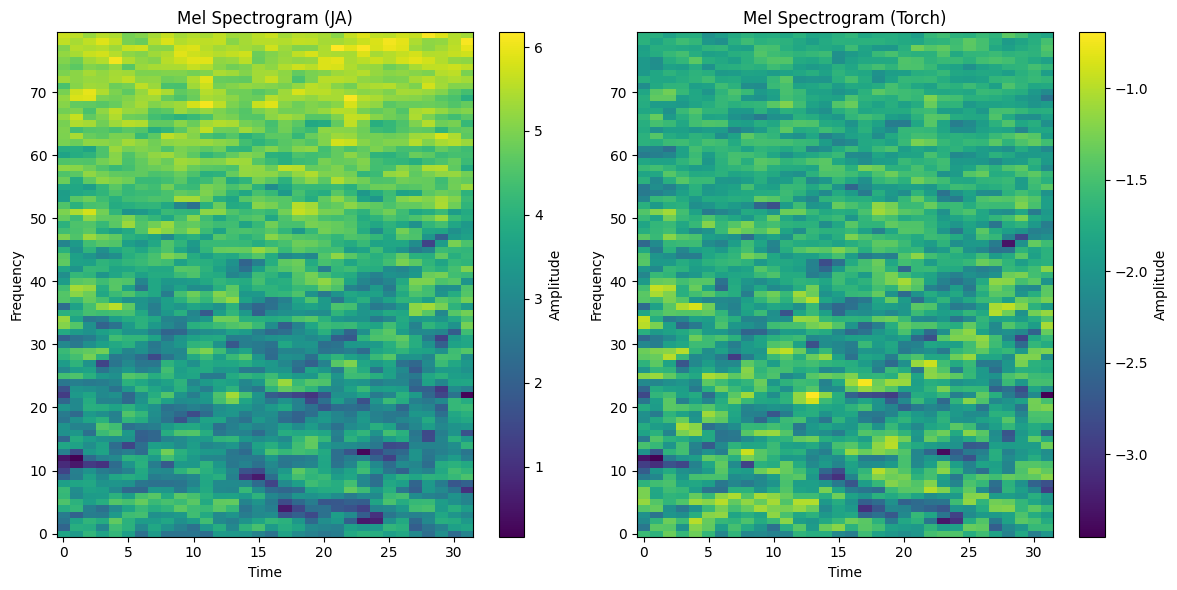

In [9]:
from librosa.util import normalize
import jax
import numpy as np

from hifigan import mel_spec_base

RANDOM = jax.random.PRNGKey(1)
SEGMENT_SIZE = 8192

def transform(wav):
    """Based off the original code that can be found here: https://github.com/jik876/hifi-gan/blob/master/meldataset.py

    Args:
        sample (dict): dict entry in HF Dataset

    Returns:
        dict: updated entry
    """
    global RANDOM, SAMPLE_RATE

    RANDOM, k = jax.random.split(RANDOM)
    wav = normalize(wav) * 0.95
    if wav.shape[0] >= SEGMENT_SIZE:
        max_audio_start = wav.shape[0] - SEGMENT_SIZE
        audio_start = jax.random.randint(k, (1,), 0, max_audio_start)[0]
        wav = wav[audio_start : audio_start + SEGMENT_SIZE]

    wav = np.expand_dims(wav, 0)
    # mel = mel_spec_base(wav=wav)
    wav1 = np.pad(
        wav,
        ((0, 0), (int((1024 - 256) / 2), int((1024 - 256) / 2))),
        mode="reflect",
    )
    mel = spec_func(wav1)
    print(mel.shape)
    print(mel)
    mel = jnp.sqrt(jnp.real(mel)**2 + jnp.imag(mel)**2 + 1e-9)
    print(mel)
    mel = mel_spec_func(mel)
    mel = jnp.log(jnp.clip(mel, min=1e-5))  # Spectral normalization

    torch_mel = mel_spectrogram(torch.from_numpy(wav).type(dtype=torch.float), n_fft=1024, hop_size=256, win_size=1024, num_mels=80, fmin=0, fmax=8000, sampling_rate=22050, center=False)


    return mel, torch_mel

import matplotlib.pyplot as plt

# Mock wav data
wav = jax.random.normal(jax.random.key(1), shape=(8192,))

# Assuming `transform` returns two mel spectrograms (from your base and Torch implementation)
ja_mel, tor_mel = transform(wav)
print(ja_mel.shape)
print(tor_mel.shape)
# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# First subplot for the "ja" mel spectrogram
plt.subplot(1, 2, 1)
plt.title("Mel Spectrogram (JA)")
plt.imshow(jnp.swapaxes(ja_mel[0], axis1=0, axis2=1), aspect="auto", origin="lower", interpolation="none")
plt.colorbar(label="Amplitude")
plt.xlabel("Time")
plt.ylabel("Frequency")

# Second subplot for the "torch" mel spectrogram
plt.subplot(1, 2, 2)
plt.title("Mel Spectrogram (Torch)")
plt.imshow(tor_mel[0], aspect="auto", origin="lower", interpolation="none")
plt.colorbar(label="Amplitude")
plt.xlabel("Time")
plt.ylabel("Frequency")

# Second subplot for the "torch" mel spectrogram
# plt.subplot(1, 2, 2)
# plt.title("Diff")
# plt.imshow(tor_mel[0]-jnp.swapaxes(ja_mel[0], axis1=0, axis2=1), aspect="auto", origin="lower", interpolation="none")
# plt.colorbar(label="Amplitude")
# plt.xlabel("Time")
# plt.ylabel("Frequency")

# Display the plots
plt.tight_layout()
plt.show()

In [2]:
import datasets
lj_speech_data = datasets.load_from_disk("transformed_lj_speech")
lj_speech_data = lj_speech_data.with_format("jax")

/home/tugdual/hifigan-jax/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from datasets import Dataset

data_dict = {
    'mel': lj_speech_data["train"]["mel"],
    'audio': lj_speech_data["train"]["audio"],
}

# Create dataset
dataset = Dataset.from_dict(data_dict)

In [ ]:
dataset = dataset.with_format("jax")

dataset.features

In [8]:
from datasets import Features, Array2D, Array3D, Value, Dataset
import time
# Define optimized features
features = Features({
    'id': Value('string'),
    'audio': Array2D(shape=(1, 8192), dtype='float32'),  # Adjust shape based on your SEGMENT_SIZE
    'mel': Array2D(shape=(80, -1), dtype='float32'),  # -1 for variable length
    'sample_rate': Value('int64'),
})

def optimize_dataset(original_dataset):
    # Convert to dictionary format
    data_dict = {
        'id': original_dataset['id'],
        'audio': original_dataset['audio'],
        'mel': original_dataset['mel'],
        'sample_rate': original_dataset['sample_rate']
    }
    
    # Create new dataset with optimized features
    start_time = time.time()
    optimized_dataset = Dataset.from_dict(data_dict, features=features)
    
    # Add JAX format
    optimized_dataset = optimized_dataset.with_format("jax")
    
    print(f"Dataset optimization took: {time.time() - start_time:.2f}s")
    return optimized_dataset

# Usage:
train_data = optimize_dataset(lj_speech_data['train'])

KeyboardInterrupt: 